The previous uploaded notebooks we focused on the Dhorka district.For this particular project we will consider the Kavrepalanchok District in Nepal.

In [2]:
# Import libraries here
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Connect

In [3]:
# connect to the SQLite database
%reload_ext sql
%sql sqlite:///nepal.sqlite

In [20]:
%%sql
-- Calculate the number of observations in the id_map table associated with district 3.
SELECT COUNT(*) AS no_observation_district_3
FROM id_map
WHERE district_id = 3

 * sqlite:///nepal.sqlite
Done.


no_observation_district_3
82684


Next i'll join the unique building IDs from Kavrepalanchok in id_map,  then add all the columns from building_structure, and the damage_grade column from building_damage. 

In [4]:
%%sql
SELECT distinct(i.building_id) AS b_id,B1.*,B2.damage_grade
FROM id_map AS i
JOIN building_structure AS B1
ON i.building_id = B1.building_id
JOIN building_damage AS B2
ON B1.building_id = B2.building_id
WHERE i.district_id = 3
LIMIT 5;

 * sqlite:///nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


## Import

Next i'll Write a wrangle function that will use the query you created in the previous task to create a DataFrame.

In [5]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)
    #Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3
    """

    # Read query results into DataFrame
    df = pd.read_sql(query,conn,index_col="b_id")

    # identify leaky features 
    drop_cols = [col for col in df.columns if "post_eq" in col] 
    
    # create a binary target
    df["damage_grade"]= df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]= (df["damage_grade"]> 3).astype(int)
    
    #drop old target
    drop_cols.append("damage_grade")
    
    # drop column on multicolinearity
    drop_cols.append("count_floors_pre_eq")
    
    # drop High-cardinality column
    drop_cols.append("building_id")
    
    #drop the column 
    df.drop(columns=drop_cols, inplace=True)
    return df

In [6]:
df = wrangle("nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


## Explore

Lets ivestigate the balance of our classes.

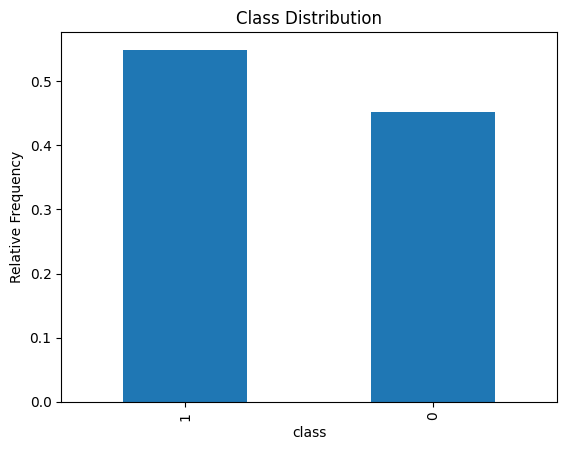

In [24]:
#Create a bar chart with the normalized value counts from the "severe_damage"
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
kind="bar", xlabel="class", ylabel="Relative Frequency", title="Class Distribution"
);

Here, seriously damaged buildings make up more than 55% of the population, while less badly damaged buildings make up roughly 45% of the data.

 Next i'll Use seaborn to create a boxplot that shows the distributions of the "plinth_area_sq_ft" column for both groups in the "severe_damage" to see if  there a relationship between the footprint size of a building and the damage it sustained in the earthquake.

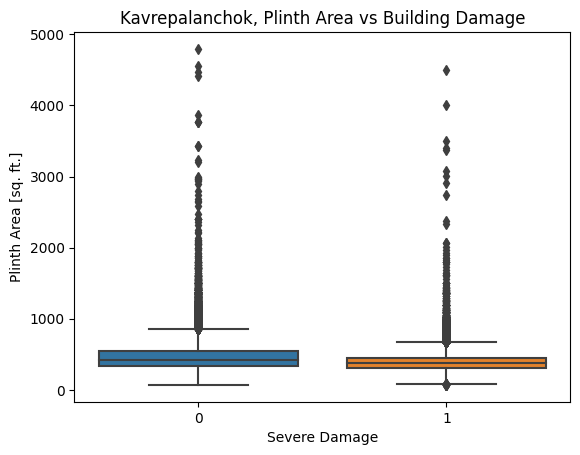

In [26]:
# Create boxplot
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

Now lets consider roof types of building in relation to the earthquake severe damage.

In [27]:
roof_pivot = pd.pivot_table(
    df, index="roof_type", values="severe_damage",aggfunc=np.mean
).sort_values(by="severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


From the pivot table , it can be seen clearly that the Bamboo category of roofs are most likely to suffer damge from the earthquake.

## Split

In [7]:
# Create your feature matrix X and target vector y. Your target is "severe_damage"
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


In [8]:
# Divide my dataset into training and validation sets using a randomized split. my validation set should be 20% of your data
X_train, X_val, y_train, y_val = train_test_split(
X, y,test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

In [30]:
# Calculate the baseline accuracy score for my model.
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

We are going to be using the logistic regression and decision tree model in this project and hence, compare there relation on the task.
    

#### Logistic regression

In [35]:
# Create a model model_lr that uses logistic regression to predict building damage
model_lr =  make_pipeline(
      OneHotEncoder(use_cat_names=True),
      LogisticRegression(max_iter=3000)
)
# Fit model to training data
model_lr.fit(X_train,y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

Now lets Calculate training and validation accuracy score for model_lr

In [34]:
lr_train_acc =  accuracy_score(y_train,model_lr.predict(X_train)) 
lr_val_acc =    model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6513735994512135
Logistic Regression, Validation Accuracy Score: 0.6527732410008493


Now lets consider the Decision tree to see if it performs bettter than the logistic regression.

### Decision tree

SInce we dont know  hyperparameter value for max_depth, i'll Create a for loop to train and evaluate the model model_dt at all depths from 1 to 15.

In [36]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt =  test_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    model_dt.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6303041191650606, 0.6303041191650606, 0.642292490118577]
Validation Accuracy Scores: [0.6350035931273273, 0.6350035931273273, 0.6453909975828053]


for visualization and to determine the most appropriate max_depth of the decision tree, i'll  Use the values in training_acc and validation_acc, plot the validation curve for model_dt.

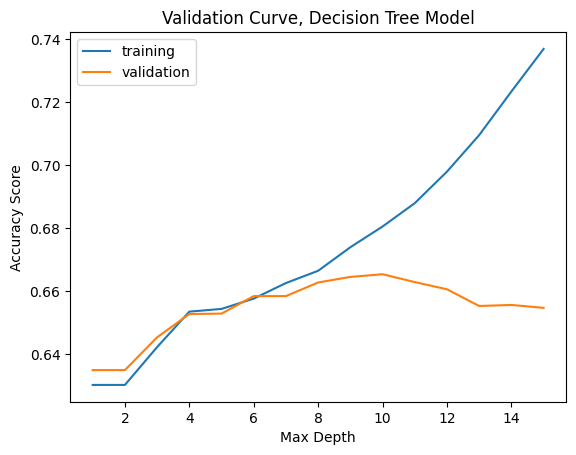

In [37]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams,training_acc,label="training")
plt.plot(depth_hyperparams,validation_acc,label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend();

to investigate further ill calculate the max-depth with the code block below.

In [38]:
# Find the index of the maximum validation accuracy score
max_val_acc_idx = np.argmax(validation_acc)

# Use the index to get the corresponding value of max_depth
optimal_max_depth = depth_hyperparams[max_val_acc_idx]

print("Optimal value for max_depth:", optimal_max_depth)

Optimal value for max_depth: 10


Next i'll Build and train a new decision tree model final_model_dt, using the value for max_depth that yielded the best validation accuracy score in your plot and calculation above.

In [39]:
final_model_dt = make_pipeline(
   OrdinalEncoder(), DecisionTreeClassifier(max_depth=10, random_state=42)
)
# Fit model to training data
final_model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
RC, engineered           4
Brick, mud mortar        5
Stone, cement mortar     6
RC, non-engineered       7
Timber                   8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

How will this model perform on a test set?

In [40]:
X_test = pd.read_csv("kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = pd.Series(final_model_dt.predict(X_test))

In [41]:
test_acc = final_model_dt.score(X_test, y_test_pred)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 1.0


A test accuracy score of 1 means that the model correctly predicted all the labels in the test set. In other words, the model has made no prediction errors on the test set. This is the best possible accuracy score that a model can achieve, and it indicates that the model has learned the underlying patterns in the data very well and can generalize to new, unseen data.

It's crucial to keep in mind, though, that the model is not always flawless if the test accuracy score is 1. There may be problems with the model memorizing the training data rather than understanding the underlying patterns, such as overfitting or data leakage. Thus, it's crucial to carry out further verifications and assessments to make sure that the model is actually operating effectively and isn't just overfitting to the training set. Cross-validation, testing on several subsets of the data, or assessing other performance metrics including precision, recall, and F1-score are some examples of how to do this.

# Communicate Results

To get the most important features for final_model_dt, I'll Create a Series Gini feat_imp. 

In [42]:
features = X_train.columns
importances =final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp =  pd.Series(importances, index=features).sort_values()
feat_imp.head()

plan_configuration        0.004189
land_surface_condition    0.008599
foundation_type           0.009967
position                  0.011795
ground_floor_type         0.013521
dtype: float64

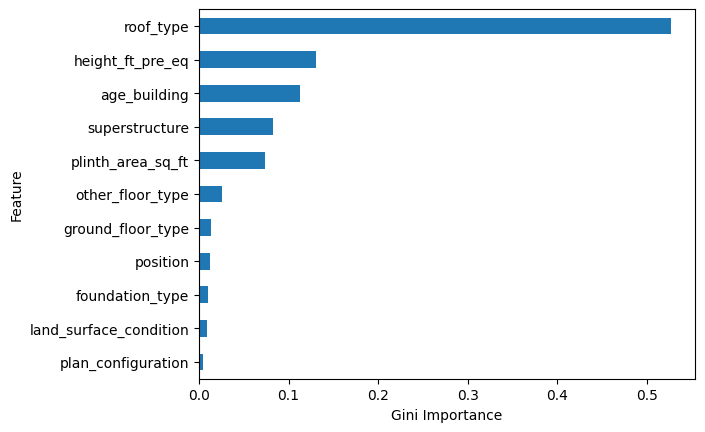

In [43]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

The roof_type is posessed with a  Gini importance score of 0.5 which suggests that the feature should not be ignored, but it should also not be overemphasized in the analysis.